# ATLAS OmniFold

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
plot_setup()

In [4]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [5]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

### Utilities

In [6]:
def standardize(data):
    orderOfMagnitude = int(math.log(np.mean(data), 10))

    return data / (10**orderOfMagnitude)

### Load ROOT file

In [7]:
zmumu = uproot.open(
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
)['EventTree']

In [8]:
zmumu.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [9]:
mybranches = []
for mykey in zmumu.keys():
    mybranches += [mykey.decode("utf-8")]

In [10]:
Events = prepare_dataset_table([
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
],
                               "EventTree",
                               branch_list=mybranches,
                               col_names=mybranches,
                               entrysteps=10000000,
                               outputype=Event_table)

Total number of events:  666677
Events in returned Object:  666677
Loading the data took  94.36755633354187  seconds


### Unpack data

In [11]:
# Event selection

# we should eventually properly account for events that fail one of Gen or Sim.  For now, just ignore them.

mypass = (Events.events['m_ll'] > 0) & (Events.events['m_ll'] < 200) & (
    Events.events['truth_m_ll'] > 0) & (Events.events['truth_m_ll'] < 200)

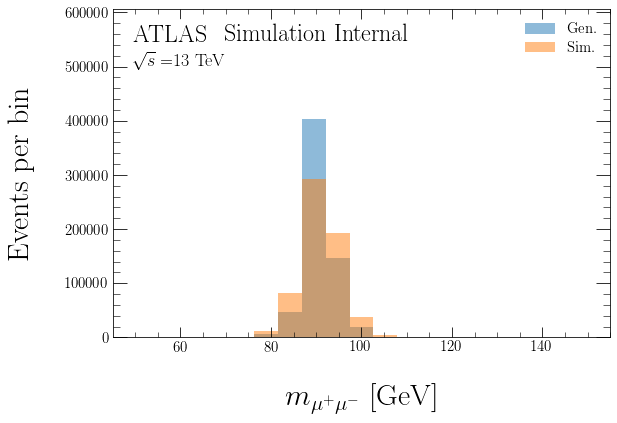

In [12]:
hG, _, _ = plt.hist(Events.events['truth_m_ll'][mypass],
                    label="Gen.",
                    bins=np.linspace(50, 150, 20),
                    alpha=0.5)
hS, _, _ = plt.hist(Events.events['m_ll'][mypass],
                    label="Sim.",
                    bins=np.linspace(50, 150, 20),
                    alpha=0.5)
plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

In [13]:
mytracks = Events.events['truth_pT_Tracks'][mypass]
ntrack_Gen = [len(mytracks[i]) for i in range(len(mytracks))]

In [14]:
mytracks = Events.events['pT_Tracks'][mypass]
ntrack_Sim = [len(mytracks[i]) for i in range(len(mytracks))]

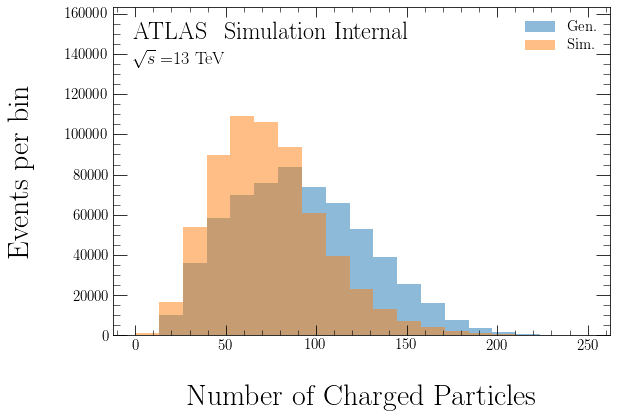

In [15]:
hG, _, _ = plt.hist(ntrack_Gen,
                    label="Gen.",
                    alpha=0.5,
                    bins=np.linspace(0, 250, 20))
hS, _, _ = plt.hist(ntrack_Sim,
                    label="Sim.",
                    alpha=0.5,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin")
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the nominal synthetic dataset, and the other half as the unknown "natural" dataset.

### Setup Datasets

In [16]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S = train_test_split(
    Events.events['truth_m_ll'][mypass],
    Events.events['m_ll'][mypass],
    test_size=0.5)

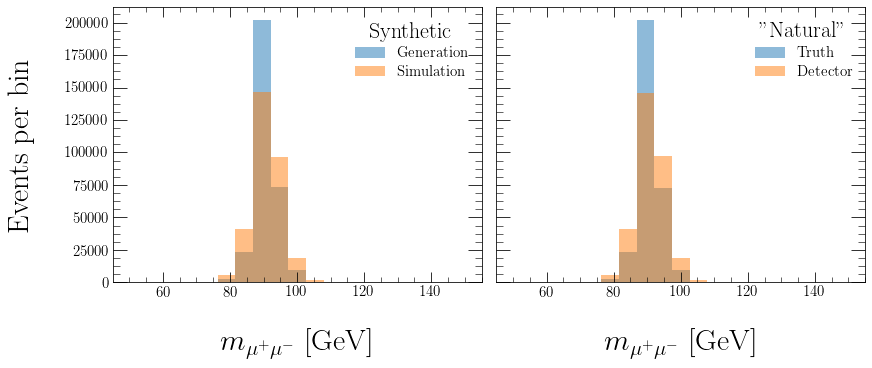

In [17]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(m_ll_0_G, bins=bins, alpha=0.5, label='Generation')
hS0, _, _ = ax[0].hist(m_ll_0_S, bins=bins, alpha=0.5, label='Simulation')
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_unknown_G, bins=bins, alpha=0.5, label='Truth')
hS1, _, _ = ax[1].hist(m_ll_unknown_S, bins=bins, alpha=0.5, label='Detector')
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

In [18]:
nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(
    np.array(ntrack_Gen), np.array(ntrack_Sim), test_size=0.5)

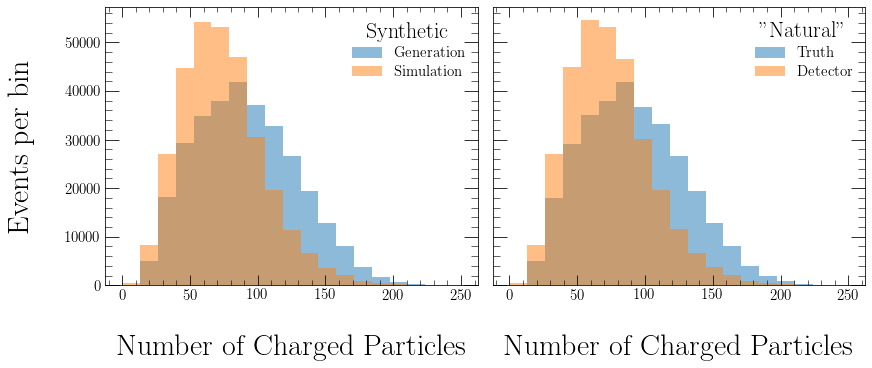

In [19]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(nTracks_0_G, bins=bins, alpha=0.5, label='Generation')
hS0, _, _ = ax[0].hist(nTracks_0_S, bins=bins, alpha=0.5, label='Simulation')
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_unknown_G, bins=bins, alpha=0.5, label='Truth')
hS1, _, _ = ax[1].hist(nTracks_unknown_S,
                       bins=bins,
                       alpha=0.5,
                       label='Detector')
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define UniFold Algorithm

In [20]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        theta0_G: nominal generation-level observable as Numpy array
                    
        theta0_G: nominal simulation-level observable as Numpy array
                    
        theta_unknown_S: "natural" (unknown) simulation-level observable 
                            to be unfolded as Numpy arrays
        
        Returns:
        A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
"""


def unifold(iterations, theta0_G, theta0_S, theta_unknown_S):
    labels0 = np.zeros(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))

    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown))

    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_G))

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    # from NN (DCTR)
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(weights)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_pull

    return weights

### Unfold $m_{\mu^+\mu^-}$

In [21]:
# simple / 100. normalization s.t. data is of order ~1

weights = unifold(iterations=2,
                  theta0_G=m_ll_0_G / 100.,
                  theta0_S=m_ll_0_S / 100.,
                  theta_unknown_S=m_ll_unknown_S / 100.)





ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 466582 samples, validate on 155528 samples
Epoch 1/200





466582/466582 [==============================] - 4s 8us/step - loss: 0.6933 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.5011
Epoch 2/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.4989
Epoch 3/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.4989
Epoch 4/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6932 - val_acc: 0.4989
Epoch 5/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5011
Epoch 6/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.4992 - val_loss: 0.6931 - 

466582/466582 [==============================] - 2s 5us/step - loss: 0.6949 - acc: 0.4994 - val_loss: 0.6949 - val_acc: 0.4992
Epoch 5/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6949 - acc: 0.5000 - val_loss: 0.6949 - val_acc: 0.4992
Epoch 6/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6949 - acc: 0.5000 - val_loss: 0.6949 - val_acc: 0.4992
Epoch 7/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6949 - acc: 0.5003 - val_loss: 0.6949 - val_acc: 0.4992
Epoch 8/200
466582/466582 [==============================] - 3s 5us/step - loss: 0.6949 - acc: 0.4999 - val_loss: 0.6949 - val_acc: 0.4992
Epoch 9/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6949 - acc: 0.4995 - val_loss: 0.6949 - val_acc: 0.4992
Epoch 10/200
466582/466582 [==============================] - 3s 5us/step - loss: 0.6949 - acc: 0.5000 - val_loss: 0.6949 - val_acc: 0.4992
Epoch 11/200
466582/466582 [==========

466582/466582 [==============================] - 3s 6us/step - loss: 0.6939 - acc: 0.4992 - val_loss: 0.6938 - val_acc: 0.4994
Epoch 10/200
466582/466582 [==============================] - 3s 5us/step - loss: 0.6939 - acc: 0.4996 - val_loss: 0.6938 - val_acc: 0.4994
Epoch 11/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6938 - acc: 0.5002 - val_loss: 0.6938 - val_acc: 0.4994
Epoch 12/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6939 - acc: 0.5011 - val_loss: 0.6939 - val_acc: 0.4994
Epoch 13/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6939 - acc: 0.5002 - val_loss: 0.6938 - val_acc: 0.4994
Epoch 14/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6938 - acc: 0.5002 - val_loss: 0.6938 - val_acc: 0.4994
Epoch 15/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6939 - acc: 0.5002 - val_loss: 0.6938 - val_acc: 0.4994
Restoring model weights from the 

ITERATION 1:


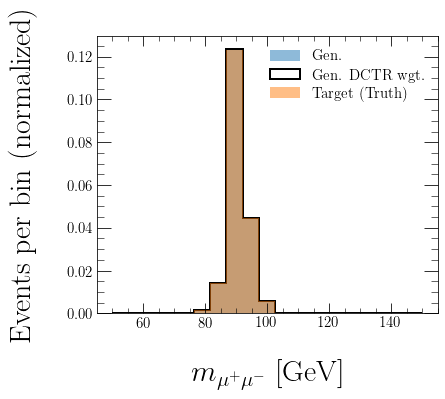

ITERATION 2:


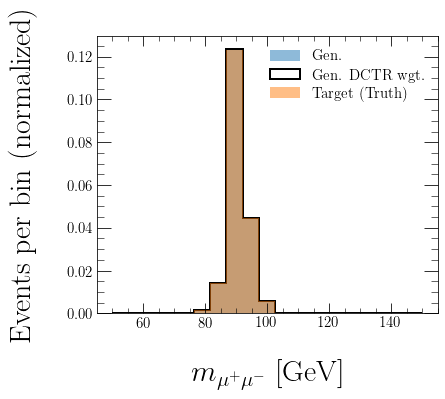

In [22]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(m_ll_0_G, bins=bins, label=r'Gen.', **plot_style_2)

    hist1 = plt.hist(m_ll_0_G,
                     bins=bins,
                     label='Gen. DCTR wgt.',
                     weights=weights[i, 1, :],
                     **plot_style_1)
    hist2 = plt.hist(m_ll_unknown_G,
                     bins=bins,
                     label=r'Target (Truth)',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

### Unfold Number of Charged Particles

In [23]:
# simple / 100. normalization s.t. data is of order ~1



weights = unifold(iterations=2,
                  theta0_G=nTracks_0_G / 100.,
                  theta0_S=nTracks_0_S / 100.,
                  theta_unknown_S=nTracks_unknown_S / 100.)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.4993
Epoch 2/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.5008
Epoch 3/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.4993
Epoch 4/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.4993
Epoch 5/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.4993
Epoch 6/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.4991
Epoch 7/200
466582/466582 [==============================] - 3s 5us/step - loss: 0.6932 - a

Epoch 3/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6935 - acc: 0.4994 - val_loss: 0.6935 - val_acc: 0.4993
Epoch 4/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.5000 - val_loss: 0.6935 - val_acc: 0.5001
Epoch 5/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.5012 - val_loss: 0.6935 - val_acc: 0.5007
Epoch 6/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.5012 - val_loss: 0.6936 - val_acc: 0.5002
Epoch 7/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6935 - acc: 0.5002 - val_loss: 0.6935 - val_acc: 0.5002
Epoch 8/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.4999 - val_loss: 0.6935 - val_acc: 0.4997
Epoch 9/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.4992 - val_loss: 0.6935 - val_acc: 0.5002
Epoch 10/200
466582/466582 

ITERATION 1:


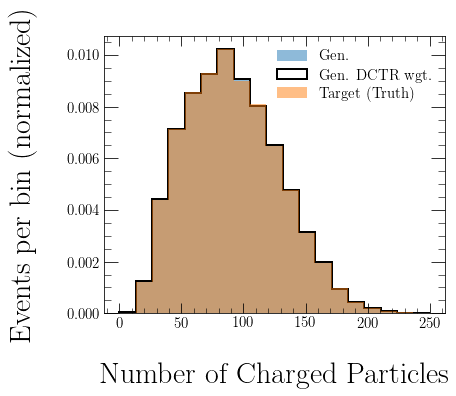

ITERATION 2:


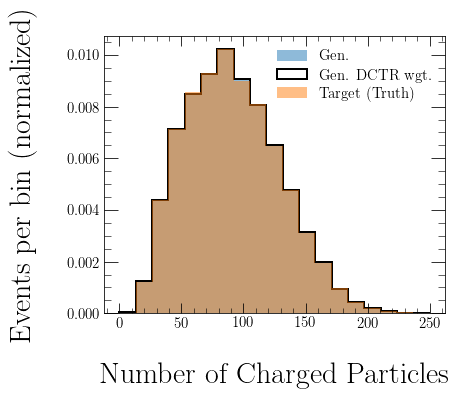

In [24]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(nTracks_0_G, bins=bins, label=r'Gen.', **plot_style_2)

    hist1 = plt.hist(nTracks_0_G,
                     bins=bins,
                     label='Gen. DCTR wgt.',
                     weights=weights[i, 1, :],
                     **plot_style_1)
    hist2 = plt.hist(nTracks_unknown_G,
                     bins=bins,
                     label=r'Target (Truth)',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"Number of Charged Particles")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the nominal synthetic dataset, and the other half as the unknown "natural" dataset.

### Setup datasets

In [25]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S, nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(
    Events.events['truth_m_ll'][mypass],
    Events.events['m_ll'][mypass],
    np.array(ntrack_Gen),
    np.array(ntrack_Sim),
    test_size=0.5)

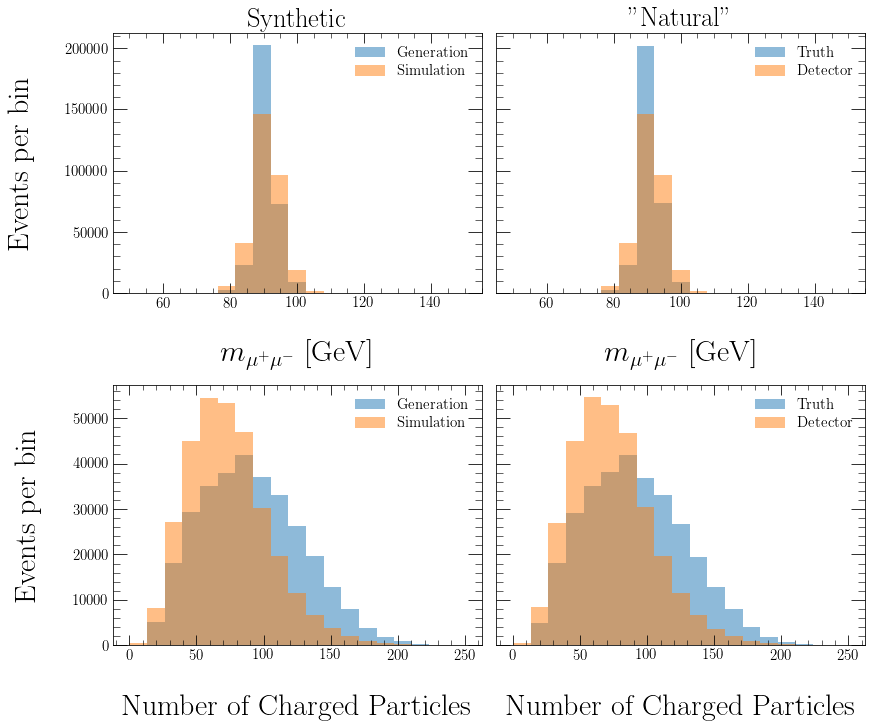

In [26]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(m_ll_0_G, bins=bins, alpha=0.5, label='Generation')
hS0, _, _ = ax[0, 0].hist(m_ll_0_S, bins=bins, alpha=0.5, label='Simulation')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_unknown_G, bins=bins, alpha=0.5, label='Truth')
hS1, _, _ = ax[0, 1].hist(m_ll_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
                          bins=bins,
                          alpha=0.5,
                          label='Generation')
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
                          bins=bins,
                          alpha=0.5,
                          label='Simulation')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
                          bins=bins,
                          alpha=0.5,
                          label='Truth')
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define MultiFold Algorithm

In [27]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):

    theta0_G = np.stack(theta0_G, axis=1)
    theta0_S = np.stack(theta0_S, axis=1)
    theta_unknown_S = np.stack(theta_unknown_S, axis=1)

    labels0 = np.zeros(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))

    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown))

    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_G))

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    # from NN (DCTR)
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(weights)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_pull

    return weights

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [28]:
num_observables = 2

# simple / 100. normalization s.t. data is of order ~1

weights = multifold(num_observables=num_observables,
                    iterations=2,
                    theta0_G=(m_ll_0_G / 100., nTracks_0_G / 100.),
                    theta0_S=(m_ll_0_S / 100., nTracks_0_S / 100.),
                    theta_unknown_S=(m_ll_unknown_S / 100.,
                                     nTracks_unknown_S / 100.))


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6935 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.4999
Epoch 2/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.4997 - val_loss: 0.6932 - val_acc: 0.5002
Epoch 3/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5001
Epoch 4/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5015
Epoch 6/200
466582/466582 [==============================] - 3s 5us/step - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5001
Epoch 7/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6932 - a

466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.5003 - val_loss: 0.6935 - val_acc: 0.5001
Epoch 16/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.5005 - val_loss: 0.6935 - val_acc: 0.4985
Epoch 17/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.5002 - val_loss: 0.6935 - val_acc: 0.5004
Epoch 18/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.5001 - val_loss: 0.6935 - val_acc: 0.4975
Epoch 19/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.5000 - val_loss: 0.6935 - val_acc: 0.4988
Epoch 20/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.4994 - val_loss: 0.6935 - val_acc: 0.4991
Epoch 21/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6935 - acc: 0.5006 - val_loss: 0.6935 - val_acc: 0.4990
Epoch 22/200
466582/466582 [=====

ITERATION: 1


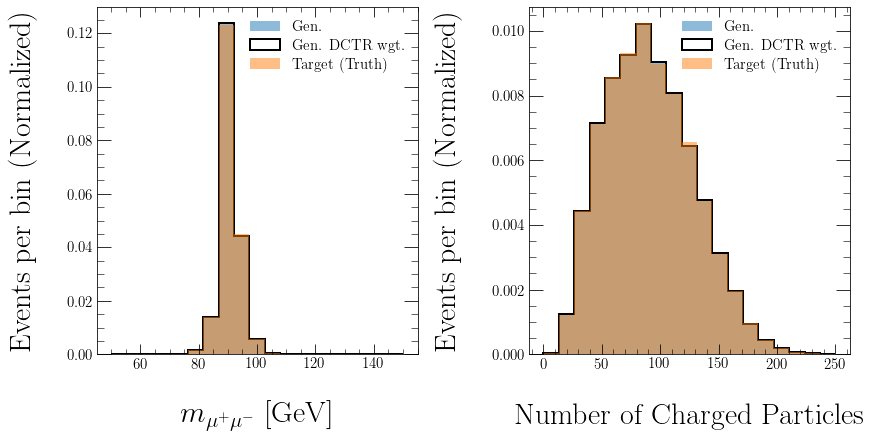

ITERATION: 2


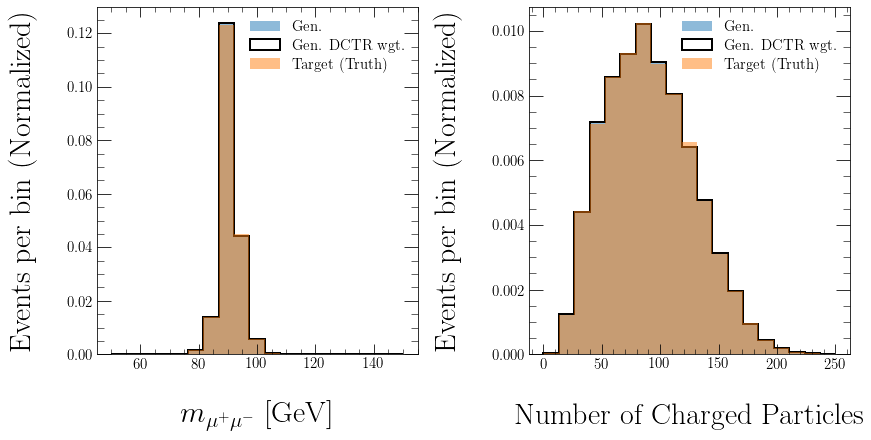

In [29]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(m_ll_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0].hist(m_ll_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(m_ll_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1].hist(nTracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)
    
    fig.show()
    plt.show()